In [1]:
import os 

# 가상 환경에서 발생하는 라이브러리 중복 로드 문제 해결
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# 기본 라이브러리 및 PyTorch 관련 모듈 불러오기
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

In [3]:
# 재현성을 위한 시드 고정
torch.manual_seed(42)
np.random.seed(42)

In [4]:
# 메타데이터를 불러와 특정 배터리를 선택
DATA_ROOT = Path("cleaned_dataset")
META_PATH = DATA_ROOT / "metadata.csv"

meta = pd.read_csv(META_PATH)

battery_id = "B0006"

# 선택한 배터리 id에 해당하는 discharge type 데이터 필터링 및 정렬
battery_meta = (
    meta[(meta["type"] == "discharge") & (meta["battery_id"] == battery_id)]
    .sort_values("start_time")
    .reset_index(drop=True)
)

# Capacity 열을 숫자형으로 변환하고 사이클 인덱스 및 soh 열 추가
battery_meta["Capacity"] = pd.to_numeric(battery_meta["Capacity"], errors="coerce")
battery_meta["cycle_index"] = np.arange(len(battery_meta))
battery_meta["soh"] = battery_meta["Capacity"] / battery_meta["Capacity"].iloc[0]

display(battery_meta[["type", "cycle_index", "soh"]].head())
print(f"사이클 수: {len(battery_meta)}")

,type,cycle_index,soh
0,discharge,0,1.000000
1,discharge,1,1.057732
2,discharge,2,1.052433
3,discharge,3,0.964158
4,discharge,4,0.933925


사이클 수: 168


In [5]:
# 데이터 로드 및 시퀀스 변환 함수 정의
SEQ_LEN = 120
WINDOW_SIZE = 3

FEATURE_COLS = [
    "Voltage_measured",
    "Current_measured",
    "Temperature_measured",
    "Current_load",
    "Voltage_load",
]

def load_cycle_sequence(filename: str, seq_len: int = SEQ_LEN) -> np.ndarray:
    """원본 csv를 고정 길이로 리샘플링"""
    path = DATA_ROOT / "data" / filename
    df = pd.read_csv(path).sort_values("Time")
    time = df["Time"].values
    new_time = np.linspace(time.min(), time.max(), seq_len)
    interpolated = []
    for col in FEATURE_COLS:
        interpolated.append(np.interp(new_time, time, df[col].values))
    return np.stack(interpolated, axis=1)

def create_sequence_windows(sequences, targets, window_size):
    """시계열 윈도우 생성"""
    X_windows = []
    y_windows = []
    for i in range(len(sequences) - window_size):
        window = sequences[i:i+window_size]
        target = targets[i+window_size]
        X_windows.append(window)
        y_windows.append(target)
    return np.array(X_windows), np.array(y_windows)

# 전체 시퀀스 데이터 로드
sequences = np.stack(
    [load_cycle_sequence(fn) for fn in battery_meta["filename"]], axis=0
)
targets = battery_meta["soh"].values

print(f"시퀀스 데이터 형태: {sequences.shape}")
print(f"타겟 데이터 형태: {targets.shape}")

시퀀스 데이터 형태: (168, 120, 5)
타겟 데이터 형태: (168,)


In [6]:
# ===================================================================
# 1단계: 개별 사이클 모델 학습 (Instant Model)
# ===================================================================

print("=" * 60)
print("1단계: 개별 사이클 독립 예측 모델 학습")
print("=" * 60)

# 시간순 분할 (80:20)
train_ratio = 0.8
split_idx = int(len(sequences) * train_ratio)

instant_train_X = sequences[:split_idx]
instant_val_X = sequences[split_idx:]
instant_train_y = targets[:split_idx]
instant_val_y = targets[split_idx:]

# 정규화
flat_train = instant_train_X.reshape(-1, len(FEATURE_COLS))
instant_mean = flat_train.mean(axis=0)
instant_std = flat_train.std(axis=0) + 1e-6

instant_train_X_norm = ((instant_train_X - instant_mean) / instant_std).astype(np.float32)
instant_val_X_norm = ((instant_val_X - instant_mean) / instant_std).astype(np.float32)

print(f"학습 데이터: {instant_train_X_norm.shape}")
print(f"검증 데이터: {instant_val_X_norm.shape}")

1단계: 개별 사이클 독립 예측 모델 학습
학습 데이터: (134, 120, 5)
검증 데이터: (34, 120, 5)


In [7]:
# Dataset 및 DataLoader 생성 (개별 사이클)
class CycleDataset(Dataset):
    def __init__(self, sequences: np.ndarray, targets: np.ndarray):
        self.x = torch.from_numpy(sequences)
        self.y = torch.from_numpy(targets.astype(np.float32))
    
    def __len__(self) -> int:
        return len(self.x)
    
    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]

instant_train_dataset = CycleDataset(instant_train_X_norm, instant_train_y)
instant_val_dataset = CycleDataset(instant_val_X_norm, instant_val_y)

BATCH_SIZE = 16

instant_train_loader = DataLoader(instant_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
instant_val_loader = DataLoader(instant_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"학습 데이터셋 크기: {len(instant_train_dataset)}")
print(f"검증 데이터셋 크기: {len(instant_val_dataset)}")

학습 데이터셋 크기: 134
검증 데이터셋 크기: 34


In [8]:
# 개별 사이클 LSTM 모델 정의 및 학습
class InstantLSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 64, num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output, (hn, _) = self.lstm(x)
        last_hidden = hn[-1]
        prediction = self.fc(last_hidden)
        return prediction.squeeze(-1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
instant_model = InstantLSTMRegressor(input_size=len(FEATURE_COLS)).to(device)

criterion = nn.MSELoss()
instant_optimizer = torch.optim.Adam(instant_model.parameters(), lr=1e-3)
EPOCHS = 30

print(f"사용 디바이스: {device}")
print(f"모델 파라미터 수: {sum(p.numel() for p in instant_model.parameters())}")

사용 디바이스: cpu
모델 파라미터 수: 51521


In [9]:
# 개별 사이클 모델 학습
instant_history = {"train_loss": [], "val_loss": []}
instant_best_val = float("inf")
instant_best_state = None

for epoch in range(1, EPOCHS + 1):
    # 학습
    instant_model.train()
    train_loss = 0.0
    for xb, yb in instant_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        instant_optimizer.zero_grad()
        preds = instant_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        instant_optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(instant_train_dataset)
    
    # 검증
    instant_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in instant_val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = instant_model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(instant_val_dataset)
    
    instant_history["train_loss"].append(train_loss)
    instant_history["val_loss"].append(val_loss)
    
    if val_loss < instant_best_val:
        instant_best_val = val_loss
        instant_best_state = instant_model.state_dict()
    
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

if instant_best_state is not None:
    instant_model.load_state_dict(instant_best_state)
    print(f"\n개별 사이클 모델 최적 검증 손실: {instant_best_val:.4f}")

Epoch 01 | Train Loss: 0.6570 | Val Loss: 0.0831
Epoch 05 | Train Loss: 0.0047 | Val Loss: 0.0035
Epoch 10 | Train Loss: 0.0012 | Val Loss: 0.0002
Epoch 15 | Train Loss: 0.0008 | Val Loss: 0.0002
Epoch 20 | Train Loss: 0.0007 | Val Loss: 0.0002
Epoch 25 | Train Loss: 0.0007 | Val Loss: 0.0002
Epoch 30 | Train Loss: 0.0008 | Val Loss: 0.0002

개별 사이클 모델 최적 검증 손실: 0.0001


In [10]:
# ===================================================================
# 2단계: 시계열 윈도우 모델 학습 (Trend Model)
# ===================================================================

print("\n" + "=" * 60)
print("2단계: 시계열 윈도우 예측 모델 학습")
print("=" * 60)

# 윈도우 데이터 생성
X_windows, y_windows = create_sequence_windows(sequences, targets, WINDOW_SIZE)

# 시간순 분할
window_split_idx = int(len(X_windows) * train_ratio)

trend_train_X = X_windows[:window_split_idx]
trend_val_X = X_windows[window_split_idx:]
trend_train_y = y_windows[:window_split_idx]
trend_val_y = y_windows[window_split_idx:]

# 정규화
trend_train_X_flat = trend_train_X.reshape(-1, SEQ_LEN, len(FEATURE_COLS))
flat_features = trend_train_X_flat.reshape(-1, len(FEATURE_COLS))
trend_mean = flat_features.mean(axis=0)
trend_std = flat_features.std(axis=0) + 1e-6

trend_train_X_norm = ((trend_train_X - trend_mean) / trend_std).astype(np.float32)
trend_val_X_norm = ((trend_val_X - trend_mean) / trend_std).astype(np.float32)

print(f"윈도우 학습 데이터: {trend_train_X_norm.shape}")
print(f"윈도우 검증 데이터: {trend_val_X_norm.shape}")


2단계: 시계열 윈도우 예측 모델 학습
윈도우 학습 데이터: (132, 3, 120, 5)
윈도우 검증 데이터: (33, 3, 120, 5)


In [11]:
# Dataset 및 DataLoader 생성 (시계열 윈도우)
class WindowDataset(Dataset):
    def __init__(self, windows: np.ndarray, targets: np.ndarray):
        N, W, S, F = windows.shape
        self.x = torch.from_numpy(windows.reshape(N, W * S, F))
        self.y = torch.from_numpy(targets.astype(np.float32))
    
    def __len__(self) -> int:
        return len(self.x)
    
    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]

trend_train_dataset = WindowDataset(trend_train_X_norm, trend_train_y)
trend_val_dataset = WindowDataset(trend_val_X_norm, trend_val_y)

trend_train_loader = DataLoader(trend_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
trend_val_loader = DataLoader(trend_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"윈도우 학습 데이터셋 크기: {len(trend_train_dataset)}")
print(f"윈도우 검증 데이터셋 크기: {len(trend_val_dataset)}")

윈도우 학습 데이터셋 크기: 132
윈도우 검증 데이터셋 크기: 33


In [12]:
# 시계열 윈도우 LSTM 모델 정의 및 학습
class TrendLSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 64, num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output, (hn, _) = self.lstm(x)
        last_hidden = hn[-1]
        prediction = self.fc(last_hidden)
        return prediction.squeeze(-1)

trend_model = TrendLSTMRegressor(input_size=len(FEATURE_COLS)).to(device)
trend_optimizer = torch.optim.Adam(trend_model.parameters(), lr=1e-3)

print(f"모델 파라미터 수: {sum(p.numel() for p in trend_model.parameters())}")

모델 파라미터 수: 51521


In [13]:
# 시계열 윈도우 모델 학습 (Early Stopping 포함)
trend_history = {"train_loss": [], "val_loss": []}
trend_best_val = float("inf")
trend_best_state = None
patience = 10
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    # 학습
    trend_model.train()
    train_loss = 0.0
    for xb, yb in trend_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        trend_optimizer.zero_grad()
        preds = trend_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        trend_optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(trend_train_dataset)
    
    # 검증
    trend_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in trend_val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = trend_model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(trend_val_dataset)
    
    trend_history["train_loss"].append(train_loss)
    trend_history["val_loss"].append(val_loss)
    
    if val_loss < trend_best_val:
        trend_best_val = val_loss
        trend_best_state = trend_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

if trend_best_state is not None:
    trend_model.load_state_dict(trend_best_state)
    print(f"\n시계열 윈도우 모델 최적 검증 손실: {trend_best_val:.4f}")

Epoch 01 | Train Loss: 0.4014 | Val Loss: 0.0367
Epoch 05 | Train Loss: 0.0071 | Val Loss: 0.0034
Epoch 10 | Train Loss: 0.0046 | Val Loss: 0.0039
Epoch 15 | Train Loss: 0.0044 | Val Loss: 0.0039
Early stopping at epoch 15

시계열 윈도우 모델 최적 검증 손실: 0.0034


In [14]:
# ===================================================================
# 3단계: 하이브리드 예측 수행
# ===================================================================

print("\n" + "=" * 60)
print("3단계: 하이브리드 예측 결합")
print("=" * 60)

def predict_instant(model, loader):
    """개별 사이클 예측"""
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds_batch = model(xb).cpu().numpy()
            preds.append(preds_batch)
            targets.append(yb.numpy())
    return np.concatenate(preds), np.concatenate(targets)

def predict_trend(model, loader):
    """윈도우 기반 예측"""
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds_batch = model(xb).cpu().numpy()
            preds.append(preds_batch)
            targets.append(yb.numpy())
    return np.concatenate(preds), np.concatenate(targets)

# 개별 사이클 예측
instant_preds, instant_targets = predict_instant(instant_model, instant_val_loader)

# 윈도우 기반 예측 (검증 데이터에 해당하는 부분만)
trend_preds, trend_targets = predict_trend(trend_model, trend_val_loader)

print(f"개별 사이클 예측 수: {len(instant_preds)}")
print(f"윈도우 기반 예측 수: {len(trend_preds)}")


3단계: 하이브리드 예측 결합
개별 사이클 예측 수: 34
윈도우 기반 예측 수: 33


In [15]:
# 하이브리드 예측 결합
# 윈도우 예측이 가능한 구간은 두 예측을 결합, 그렇지 않으면 개별 사이클 예측만 사용

# 검증 데이터의 시작 인덱스
val_start_cycle = split_idx
window_start_in_val = window_split_idx + WINDOW_SIZE - val_start_cycle

# 하이브리드 가중치 (튜닝 가능)
instant_weight = 0.6
trend_weight = 0.4

# 결합 예측 생성
hybrid_preds = instant_preds.copy()

# 윈도우 예측이 가능한 구간에서 결합
if window_start_in_val >= 0 and window_start_in_val < len(instant_preds):
    overlap_length = min(len(trend_preds), len(instant_preds) - window_start_in_val)
    
    for i in range(overlap_length):
        instant_idx = window_start_in_val + i
        trend_idx = i
        hybrid_preds[instant_idx] = (
            instant_weight * instant_preds[instant_idx] +
            trend_weight * trend_preds[trend_idx]
        )

print(f"하이브리드 예측 생성 완료")
print(f"윈도우 예측 결합 구간: {window_start_in_val} ~ {window_start_in_val + overlap_length}")

하이브리드 예측 생성 완료
윈도우 예측 결합 구간: 1 ~ 34


In [16]:
# ===================================================================
# 4단계: 성능 비교 및 평가
# ===================================================================

print("\n" + "=" * 60)
print("4단계: 성능 평가")
print("=" * 60)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 개별 사이클 모델 성능
instant_mae = mean_absolute_error(instant_targets, instant_preds)
instant_rmse = np.sqrt(mean_squared_error(instant_targets, instant_preds))
instant_r2 = r2_score(instant_targets, instant_preds)

# 시계열 윈도우 모델 성능
trend_mae = mean_absolute_error(trend_targets, trend_preds)
trend_rmse = np.sqrt(mean_squared_error(trend_targets, trend_preds))
trend_r2 = r2_score(trend_targets, trend_preds)

# 하이브리드 모델 성능
hybrid_mae = mean_absolute_error(instant_targets, hybrid_preds)
hybrid_rmse = np.sqrt(mean_squared_error(instant_targets, hybrid_preds))
hybrid_r2 = r2_score(instant_targets, hybrid_preds)

# 결과 출력
print("\n[개별 사이클 모델 (Instant)]")
print(f"  MAE:  {instant_mae:.4f}")
print(f"  RMSE: {instant_rmse:.4f}")
print(f"  R²:   {instant_r2:.4f}")

print("\n[시계열 윈도우 모델 (Trend)]")
print(f"  MAE:  {trend_mae:.4f}")
print(f"  RMSE: {trend_rmse:.4f}")
print(f"  R²:   {trend_r2:.4f}")

print("\n[하이브리드 모델 (Hybrid)]")
print(f"  MAE:  {hybrid_mae:.4f}")
print(f"  RMSE: {hybrid_rmse:.4f}")
print(f"  R²:   {hybrid_r2:.4f}")

# 성능 향상률 계산
mae_improvement = ((instant_mae - hybrid_mae) / instant_mae) * 100
rmse_improvement = ((instant_rmse - hybrid_rmse) / instant_rmse) * 100

print(f"\n[하이브리드 모델 개선율]")
print(f"  MAE 개선:  {mae_improvement:+.2f}%")
print(f"  RMSE 개선: {rmse_improvement:+.2f}%")


4단계: 성능 평가

[개별 사이클 모델 (Instant)]
  MAE:  0.0125
  RMSE: 0.0156
  R²:   0.9621

[시계열 윈도우 모델 (Trend)]
  MAE:  0.0487
  RMSE: 0.0625
  R²:   0.4135

[하이브리드 모델 (Hybrid)]
  MAE:  0.0165
  RMSE: 0.0257
  R²:   0.8976

[하이브리드 모델 개선율]
  MAE 개선:  -32.35%
  RMSE 개선: -64.41%


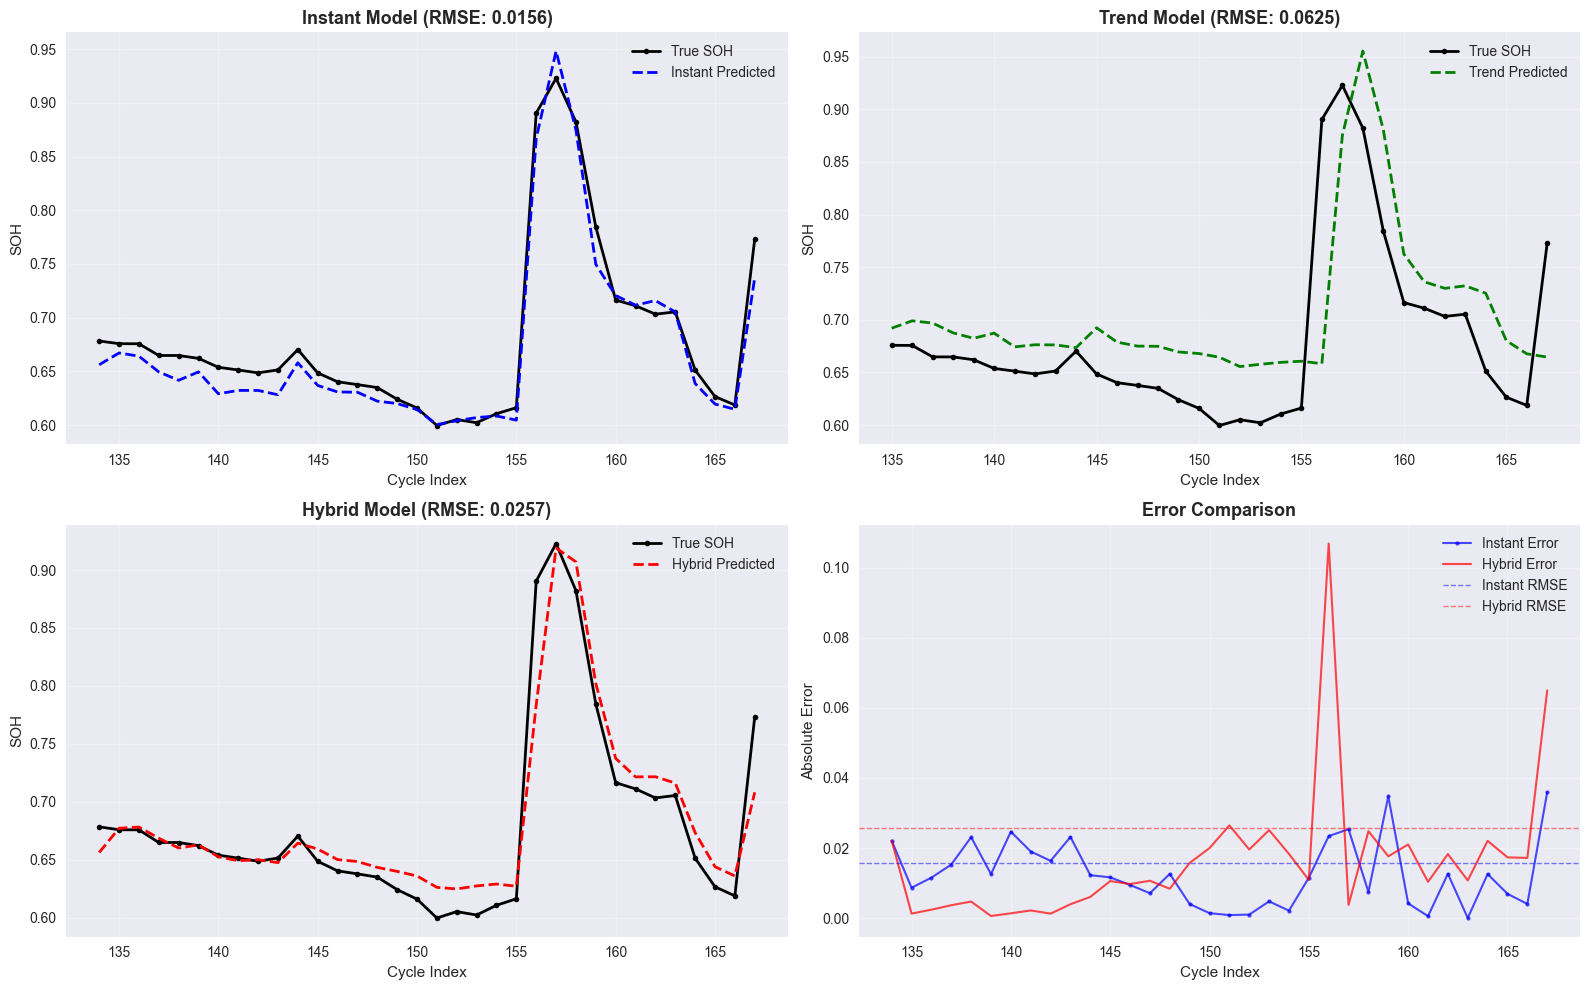

In [17]:
# ===================================================================
# 5단계: 시각화 - 세 모델 비교
# ===================================================================

val_cycles = np.arange(val_start_cycle, len(battery_meta))

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. 개별 사이클 모델
ax1 = axes[0, 0]
ax1.plot(val_cycles, instant_targets, label="True SOH", marker="o", markersize=4, linewidth=2, color='black')
ax1.plot(val_cycles, instant_preds, label="Instant Predicted", marker="x", markersize=4, linewidth=2, linestyle="--", color='blue')
ax1.set_xlabel("Cycle Index", fontsize=11)
ax1.set_ylabel("SOH", fontsize=11)
ax1.set_title(f"Instant Model (RMSE: {instant_rmse:.4f})", fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# 2. 시계열 윈도우 모델
ax2 = axes[0, 1]
trend_cycles = val_cycles[window_start_in_val:window_start_in_val + len(trend_preds)]
ax2.plot(trend_cycles, trend_targets, label="True SOH", marker="o", markersize=4, linewidth=2, color='black')
ax2.plot(trend_cycles, trend_preds, label="Trend Predicted", marker="x", markersize=4, linewidth=2, linestyle="--", color='green')
ax2.set_xlabel("Cycle Index", fontsize=11)
ax2.set_ylabel("SOH", fontsize=11)
ax2.set_title(f"Trend Model (RMSE: {trend_rmse:.4f})", fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

# 3. 하이브리드 모델
ax3 = axes[1, 0]
ax3.plot(val_cycles, instant_targets, label="True SOH", marker="o", markersize=4, linewidth=2, color='black')
ax3.plot(val_cycles, hybrid_preds, label="Hybrid Predicted", marker="x", markersize=4, linewidth=2, linestyle="--", color='red')
ax3.set_xlabel("Cycle Index", fontsize=11)
ax3.set_ylabel("SOH", fontsize=11)
ax3.set_title(f"Hybrid Model (RMSE: {hybrid_rmse:.4f})", fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=10)

# 4. 세 모델 오차 비교
ax4 = axes[1, 1]
instant_errors = np.abs(instant_preds - instant_targets)
hybrid_errors = np.abs(hybrid_preds - instant_targets)

ax4.plot(val_cycles, instant_errors, label="Instant Error", marker="o", markersize=3, linewidth=1.5, alpha=0.7, color='blue')
ax4.plot(val_cycles, hybrid_errors, label="Hybrid Error", marker="x", markersize=3, linewidth=1.5, alpha=0.7, color='red')
ax4.axhline(y=instant_rmse, color='blue', linestyle='--', linewidth=1, alpha=0.5, label=f'Instant RMSE')
ax4.axhline(y=hybrid_rmse, color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Hybrid RMSE')
ax4.set_xlabel("Cycle Index", fontsize=11)
ax4.set_ylabel("Absolute Error", fontsize=11)
ax4.set_title("Error Comparison", fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend(fontsize=10)

plt.tight_layout()
plt.show()

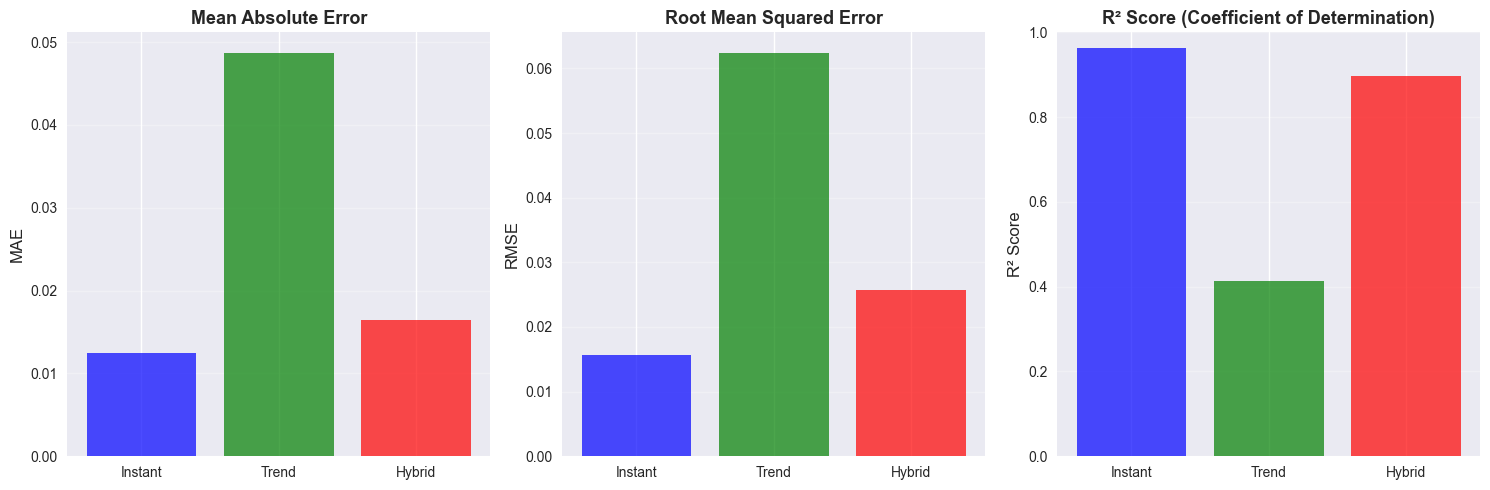


하이브리드 모델 분석 완료!


In [18]:
# ===================================================================
# 6단계: 성능 비교 막대 그래프
# ===================================================================

metrics_data = {
    'Model': ['Instant', 'Trend', 'Hybrid'],
    'MAE': [instant_mae, trend_mae, hybrid_mae],
    'RMSE': [instant_rmse, trend_rmse, hybrid_rmse],
    'R²': [instant_r2, trend_r2, hybrid_r2]
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MAE 비교
axes[0].bar(metrics_data['Model'], metrics_data['MAE'], color=['blue', 'green', 'red'], alpha=0.7)
axes[0].set_ylabel('MAE', fontsize=12)
axes[0].set_title('Mean Absolute Error', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# RMSE 비교
axes[1].bar(metrics_data['Model'], metrics_data['RMSE'], color=['blue', 'green', 'red'], alpha=0.7)
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_title('Root Mean Squared Error', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# R² 비교
axes[2].bar(metrics_data['Model'], metrics_data['R²'], color=['blue', 'green', 'red'], alpha=0.7)
axes[2].set_ylabel('R² Score', fontsize=12)
axes[2].set_title('R² Score (Coefficient of Determination)', fontsize=13, fontweight='bold')
axes[2].set_ylim([0, 1])
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n하이브리드 모델 분석 완료!")